### 1. Import and check data

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import os
import scipy
from sklearn.model_selection import train_test_split
from scipy.stats import percentileofscore
import random
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_path = './instacart_2017_05_01/'
output_path = './output/'

In [3]:
orders = pd.read_csv(os.path.join(data_path, 'orders.csv'))
order_products_train = pd.read_csv(os.path.join(data_path, 'order_products__train.csv'))
order_products_prior = pd.read_csv(os.path.join(data_path, 'order_products__prior.csv'))
products = pd.read_csv(os.path.join(data_path, 'products.csv'))

In [4]:
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


Check the distribution.

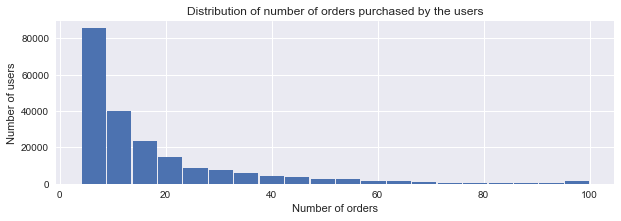

In [5]:
fig = plt.figure(figsize=(10,3))
n_,b_,p_ = plt.hist(orders.groupby("user_id")['order_id'].count(), bins=20, rwidth=0.95)
plt.title("Distribution of number of orders purchased by the users")
plt.xlabel("Number of orders")
plt.ylabel("Number of users")

In [6]:
print("The number of orders: %s" % len(orders))
assert(len(orders) == len(orders.order_id.unique()))
print("The number of unique users: %s" % len(orders.user_id.unique()))
print("The number of unique products: %s" % len(order_products_prior.product_id.unique()))

The number of orders: 3421083
The number of unique users: 206209
The number of unique products: 49677


Check the nulls.

In [7]:
np.sum(orders.isnull())

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

The number of NaN entries is equal to the number of unique users. Can deduce that each user has one NaN for the very first order he/she has placed, because it itself is the prior order. When NEEDED, these NaNs can be filled by zeros, which makes sense.

The distruibution of Hours of Day also makes sense.

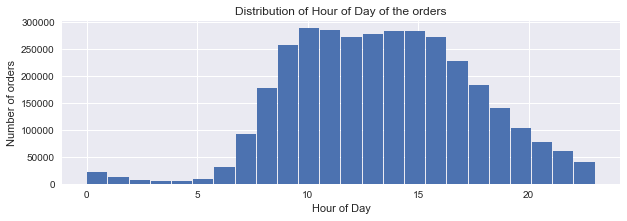

In [8]:
fig = plt.figure(figsize=(10,3))
n_, b_, p_ = plt.hist(orders.order_hour_of_day, bins=24, rwidth=0.95)
plt.title("Distribution of Hour of Day of the orders")
plt.xlabel("Hour of Day")
plt.ylabel("Number of orders")

### 2. Preprocessing

Transform the data files into another format with (user, product) k-v pairs for the purpose of recommending the products to users. 

In [9]:
orders.eval_set.unique()

array(['prior', 'train', 'test'], dtype=object)

Focus on the orders having eval_set = “prior” and ignore the other rows.

In [10]:
orders_prior = orders[orders.eval_set == 'prior']
print("The prior data takes %.2f%% of the whole." % (len(orders_prior)*100./len(orders)))

The prior data takes 93.97% of the whole.


Join `order_products_prior` with `orders_prior` on column `order_id`.

In [11]:
user_product = order_products_prior.set_index('order_id').join(orders_prior.set_index('order_id')).reset_index()
user_product.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,202279,prior,3,5,9,8.0
1,2,28985,2,1,202279,prior,3,5,9,8.0
2,2,9327,3,0,202279,prior,3,5,9,8.0
3,2,45918,4,1,202279,prior,3,5,9,8.0
4,2,30035,5,0,202279,prior,3,5,9,8.0


Persist the user_product pairs to ``.csv`` file.

In [12]:
user_product_save = user_product[['user_id', 'product_id']].copy()
user_product_save['count'] = pd.Series(np.zeros(len(user_product_save)), index=user_product_save.index)
user_product_save = user_product_save.groupby(['user_id', 'product_id'], as_index=False).count()
user_product_save.to_csv(data_path + "user_product.csv")

Split the user_product in 70% train, 30% test, noting that:

- Every user appears both in the train and in the test set. Similarly, make sure that every product appears both in the train and in the test set.
- If a pair ``<user_x, product_y>`` appears in the training set at least once, it must not appear in the test set.
- In the test set, for each user, add 1000 random products that that particular user has not bought yet.

In [13]:
user_product = pd.read_csv(data_path + "user_product.csv", index_col=0)

The statistics about the number of products the users have bought.

In [14]:
user_product_counts = user_product.groupby('user_id').count()['count']
product_user_counts = user_product.groupby('product_id').count()['count']

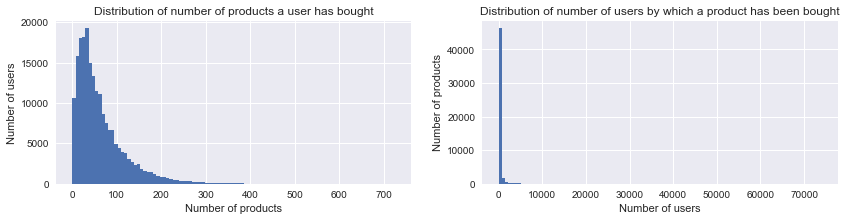

In [15]:
fig = plt.figure(figsize=(14,3))
f1 = fig.add_subplot(1,2,1)
plt.hist(user_product_counts, bins=100)
f1.set_title("Distribution of number of products a user has bought")  
plt.xlabel("Number of products")
plt.ylabel("Number of users")
f2 = fig.add_subplot(1,2,2)
plt.hist(product_user_counts, bins=100)
f2.set_title("Distribution of number of users by which a product has been bought")
plt.xlabel("Number of users")
plt.ylabel("Number of products")

Need to determine a threshold to select the users and products for next steps.

In [16]:
def percentage_remaining(series, threshold):
    return sum(series > threshold) * 1. / len(series)

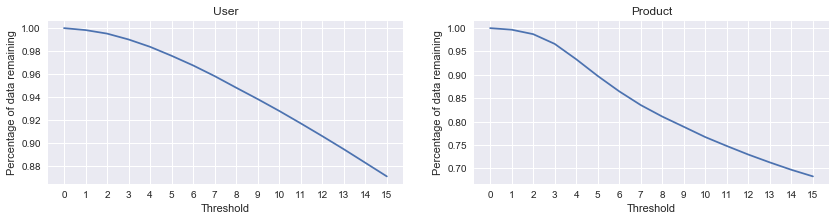

In [17]:
X = range(16)
fig = plt.figure(figsize=(14,3))
f1 = fig.add_subplot(1,2,1)
plt.plot(X, [percentage_remaining(user_product_counts, i) for i in X])
f1.set_title("User")  
plt.xticks(X)
plt.xlabel("Threshold")
plt.ylabel("Percentage of data remaining")
f2 = fig.add_subplot(1,2,2)
f2.plot(X, [percentage_remaining(product_user_counts, i) for i in X])
f2.set_title("Product")
plt.xticks(X)
plt.xlabel("Threshold")
plt.ylabel("Percentage of data remaining")

### 3. Split the data

Check the sparsity of the data.

In [18]:
sparsity = len(user_product)*1.0 / (len(user_product.user_id.unique()) * len(user_product.product_id.unique()))
print("Sparsity: %s" % sparsity)

Sparsity: 0.00129911704625


Need to preserve only the common users and products.

In [19]:
def remove_rows(df, user_threshold=10, product_threshold=4, min_percentage=0.85):
    c1, c2 = df, df
    n = len(df)
    # Iteratively remove the user_id and product_id
    # because they are affected by each other
    # until no changes between iteration or minimum percentage reached
    while True:
        u_p_count = c2.groupby('user_id').count()['count']
        c1 = c2[(True^c2['user_id'].isin(u_p_count[u_p_count<user_threshold].index))]
        num1 = len(c1)
        p_u_count = c1.groupby('product_id').count()['count']
        c2 = c1[(True^c1['product_id'].isin(p_u_count[p_u_count<product_threshold].index))]
        num2 = len(c2)
        if num1 == num2 or min(num1, num2)*1./n <= min_percentage:
            break
    return c1

In [20]:
user_product = remove_rows(user_product, 10, 4, 0.85)

In [21]:
def split_train_test(user_product, train_size=0.7):
    train, test = train_test_split(user_product, train_size=train_size)
    tr, te = train, test
    while True:
        user_tr, user_te = set(tr.user_id), set(te.user_id)
        product_tr, product_te = set(tr.product_id), set(te.product_id)
        if user_tr == user_te and product_tr == product_te:
            break
        user_common = user_tr & user_te
        product_common = product_tr & product_te
        tr = tr[tr['user_id'].isin(user_common)]
        te = te[te['user_id'].isin(user_common)]
        tr = tr[tr['product_id'].isin(product_common)]
        te = te[te['product_id'].isin(product_common)]
    return tr, te

In [22]:
train, test = split_train_test(user_product)

In [23]:
n_u = len(set(train.user_id))
n_p = len(set(train.product_id))
r_u = n_u*100./len(user_product.user_id.unique())
r_p = n_p*100./len(user_product.product_id.unique())
print("There are %s users and %s products in the train and test sets." % (n_u, n_p))
print("Preserved %.2f%% of users and %.2f%% of products." % (r_u, r_p))

There are 193269 users and 46721 products in the train and test sets.
Preserved 99.88% of users and 97.38% of products.


### 4. Model 

Implement Collaborative Filtering on the implicit purchase data. 

In [24]:
def get_purchase(user):
    # Extract the purchase information of the user to (product_id, count) k-v pairs.
    return dict(zip(user['product_id'], user['count']))

In [25]:
users_tr = dict(list(train.groupby('user_id')))
users_te = dict(list(test.groupby('user_id')))
assert(set(users_tr.keys()) == set(users_te.keys()))
user_ids = set(users_tr.keys())

for u in users_tr:
    users_tr[u] = get_purchase(users_tr[u])
    users_te[u] = get_purchase(users_te[u])    
# The container for the predictions.
users_pr = dict()

Define Pearson Similarity as:

${sim(x,y) = \cfrac{\Sigma_{s \in S_{xy}} (r_{xs} - \overline r_x)(r_{ys} - \overline r_y)}
{\sqrt{\Sigma_{s \in S_{xy}} (r_{xs} - \overline r_x)^2} \sqrt{\Sigma_{s \in S_{xy}} (r_{ys} - \overline r_y)^2}}}$

In which $S_{xy}$ are the items purchased by both users `x` and `y`. 

If none of the users who are most simlilar have purchased the item, the prediction would be zero.

In [26]:
def pearson_similarity(purchase_a, purchase_b, min_common_purchases=2):
    avg_a, avg_b = np.mean(purchase_a.values()), np.mean(purchase_b.values())
    common_keys = [p for p in purchase_a if p in purchase_b]
    if len(common_keys) < min_common_purchases:
        return 0.0
    a = np.array([purchase_a[x] for x in common_keys]) - avg_a
    b = np.array([purchase_b[x] for x in common_keys]) - avg_b
    den = np.linalg.norm(a) * np.linalg.norm(b)
    if not den:
        return 0.0
    return float(sum(a * b)) / den

In [27]:
def predict(uid, users_tr, users_te, user_ids, to_predict=None, k=100):
    # the prediction for user_id uid, using k most similar users' purchase information
    u = users_tr[uid]
    sim_ranks = [(i, pearson_similarity(users_tr[i], u)) for i in user_ids if i != uid]
    sim_ranks = sorted(sim_ranks, key=lambda x:-x[1])
    most_similar = sim_ranks[:k]
    if not to_predict:
        to_predict = users_te[uid].keys()
    res = dict()
    for tp in to_predict:
        similarities = np.array([y for x,y in most_similar])
        purchases = np.array([users_tr[x].get(tp, 0) for x,y in most_similar])
        f = (purchases > 0).astype(int) # filter
        if sum(similarities * f) != 0.0:
            r_xi = float(sum(similarities * purchases)) / sum(similarities * f)
        else:
            r_xi = 0.0 # not bought by any similar users
        res[tp] = r_xi
    return res

Use percentile ranking for the evaluation due to the reason of being unable to track user reactions to the recommendations.


In [28]:
def get_ranks(uid, users_te):
    user = users_te[uid]
    res = {}
    vals = sorted(user.values())
    for i in user:
        res[i] = (100.0 - percentileofscore(vals, user[i], kind='weak')) / 100
    return res

In [29]:
def get_avg_rank(uids, users_tr, users_te):
    num, den = 0, 0
    for uid in uids:
        ranks = get_ranks(uid, users_te)
        if uid not in users_pr:
            users_pr[uid] = predict(uid, users_tr, users_te)
        pred = users_pr[uid]
    
        for i in ranks:
            num += ranks[i] * pred[i]
            den += pred[i]
    return num / den if den else 0.5

In [30]:
def run(uids, users_tr, users_te, products_to_predict=None):
    global users_pr
    users_pr = {}
    if not products_to_predict:
        for uid in uids:
            users_pr[uid] = predict(uid, users_tr, users_te, uids)
    else:
        for uid in uids:
            users_pr[uid] = predict(uid, users_tr, users_te, uids, products_to_predict[uid])

In [31]:
def save_predictions(users_pr, file_name):
    df = pd.DataFrame([(u, p, users_pr[u][p]) for u in users_pr for p in users_pr[u]],\
                      columns=['user_id', 'product_id', 'count']) 
    file_path = os.path.join(output_path, file_name)
    df.to_csv(file_path)
    print("Results saved to %s" % file_path)

Select samples randomly for experiment.

In [32]:
def sample(num=1000):
    global user_ids
    global users_tr
    global users_te
    user_ids_sample = set(random.sample(user_ids, num))
    users_tr_sample, users_te_sample = {}, {}
    for uid in user_ids_sample:
        users_tr_sample[uid] = users_tr[uid]
        users_te_sample[uid] = users_te[uid]
    return user_ids_sample, users_tr_sample, users_te_sample

Sample 2000 users for experimenting.

In [33]:
user_ids_sample, users_tr_sample, users_te_sample = sample(2000)

In [34]:
run(user_ids_sample, users_tr_sample, users_te_sample)

Computer the percentile-ranking of the algorithm defined as:

${\overline{rank} = \cfrac{\Sigma_{u,i}r_{ui}^t rank_{ui}}{\Sigma_{u,i}r_{ui}^t}}$


In [35]:
avg_rank = get_avg_rank(user_ids_sample, users_tr_sample, users_te_sample)
print("The average rank: %s" % avg_rank)

The average rank: 0.252614444578


In [36]:
save_predictions(users_pr, 'validations.csv')

Results saved to ./output/validations.csv


### 5. Add random products

Add 1000 random products for each user that that particular user has not bought yet and predict which products the user is going to buy.

In [37]:
product_ids = set(train.product_id)

In [38]:
n_random_prod = 1000
products_random = dict([(uid, \
                         random.sample(product_ids - set(users_tr[uid].keys() + users_te[uid].keys()), \
                         n_random_prod)) \
                        for uid in user_ids_sample])

In [39]:
run(user_ids_sample, users_tr_sample, users_te_sample, products_random)

In [40]:
save_predictions(users_pr, 'predictions.csv')

Results saved to ./output/predictions.csv


Interperate the result as: refer the column `count` in the `predictions.csv` and recommend the products with `count` larger than zero to the corresponding user. The value of `count` could be the reflection of the preference to the product by the user.

In [41]:
result = pd.read_csv(os.path.join(output_path, 'predictions.csv'), index_col=0)

In [42]:
recommends = result[result['count'] >= 1][['user_id', 'product_id']]
perc = len(recommends)*1./len(result)
print("In average, %s%% of the products can be recommended to users." % (perc*100))

In average, 6.26125% of the products can be recommended to users.


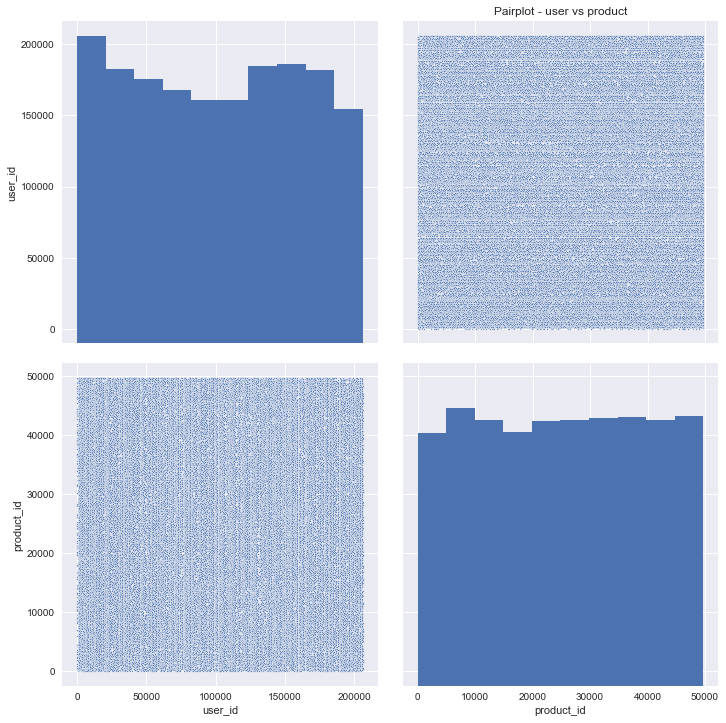

In [46]:
sns.pairplot(recommends, size=5, kind='scatter',plot_kws={"s": 2})
plt.title("Pairplot - user vs product")

**Lin Zhuo
1/28/2018**